In [1]:
import matplotlib.pyplot as plt
import muon
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import glob
import os
import re
import sys 

/data/jiangjunyao/miniconda3/envs/normal/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/data/jiangjunyao/miniconda3/envs/normal/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
adata = sc.read_h5ad('/data/jiangjunyao/polyATAC/multiomi/peak_ct.h5ad')
min_cells = int(adata.shape[0] * 0.05)
sc.pp.filter_genes(adata, min_cells=min_cells)
adata.var["name"]  = adata.var_names
split_interval = adata.var["name"].str.split("-", expand=True)
adata.var["chr"] = split_interval[0]
adata.var["start"] = split_interval[1].astype(int)
adata.var["end"] = split_interval[2].astype(int)
mask = adata.var["chr"].str.startswith("chr")
adata = adata[:, mask].copy()

In [4]:
scvi.data.add_dna_sequence(
            adata,
            genome_name="mm10",
            genome_dir="/data/jiangjunyao/software/scbasset/data",
            chr_var_key="chr",
            start_var_key="start",
            end_var_key="end",
            install_genome = True
        )

14:43:13 | INFO | Downloading assembly summaries from GENCODE
14:43:59 | INFO | Downloading assembly summaries from UCSC
14:44:11 | INFO | Downloading assembly summaries from Ensembl
14:44:58 | INFO | Downloading genome from UCSC. Target URL: https://hgdownload.soe.ucsc.edu/goldenPath/mm10/bigZips/chromFa.tar.gz...


Download:   0%|          | 0.00/830M [00:00<?, ?B/s]

14:46:25 | INFO | Genome download successful, starting post processing...
14:46:44 | INFO | name: mm10
14:46:44 | INFO | local name: mm10
14:46:44 | INFO | fasta: /data/jiangjunyao/software/scbasset/data/mm10/mm10.fa


Filtering Fasta: 0.00 lines [00:00, ? lines/s]

Working...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 16.98it/s]


In [5]:
##start train
bdata = adata.transpose()
bdata.layers["binary"] = (bdata.X.copy() > 0).astype(float)
scvi.external.SCBASSET.setup_anndata(bdata, layer="binary", dna_code_key="dna_code")
bas = scvi.external.SCBASSET(bdata)
bas.train(precision=16,batch_size=256)
latent = bas.get_latent_representation()
adata.obsm["X_scbasset"] = latent

/data/jiangjunyao/miniconda3/envs/normal/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


INFO     Using column names from columns of adata.obsm['dna_code']                                                 


/data/jiangjunyao/miniconda3/envs/normal/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/data/jiangjunyao/miniconda3/envs/normal/lib/python3.10/site-packages/lightning/fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, 

Epoch 1000/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:18:43<00:00,  4.68s/it, v_num=1, train_loss_step=0.306, train_loss_epoch=0.314]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:18:43<00:00,  4.72s/it, v_num=1, train_loss_step=0.306, train_loss_epoch=0.314]


/data/jiangjunyao/miniconda3/envs/normal/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/jiangjunyao/miniconda3/envs/normal/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


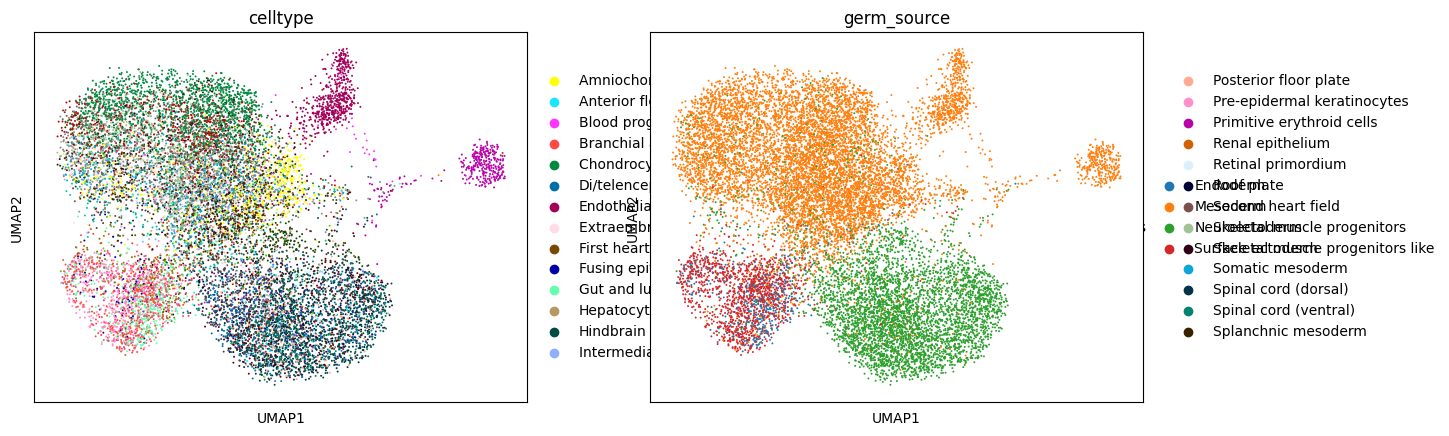

In [8]:
sc.pp.neighbors(adata, use_rep="X_scbasset")
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_scbasset")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)  
sc.pl.umap(adata,color=['celltype','germ_source'])

In [19]:
adata.obsm['X_scbasset'].shape

(15194, 32)

<AxesSubplot: xlabel='epoch'>

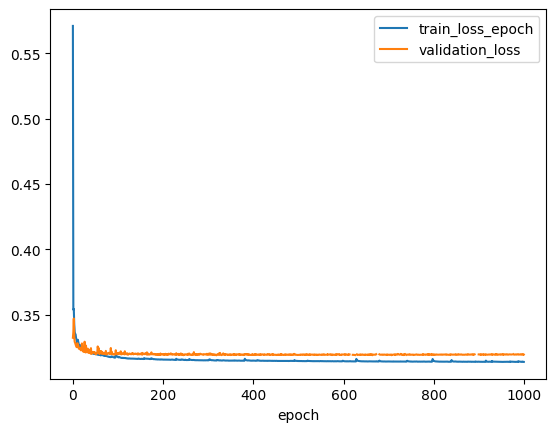

In [23]:
fig, ax = plt.subplots()
bas.history_["train_loss_epoch"].plot(ax=ax)
bas.history_["validation_loss"].plot(ax=ax)

In [26]:
del adata.varm
adata.write_h5ad('/data/jiangjunyao/polyATAC/multiomi/peak_ct.h5ad_scbasset.h5ad')
pd.DataFrame(adata.obsm['X_scbasset']).to_csv('/data/jiangjunyao/polyATAC/multiomi/scbasset_rep.csv')